In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# UNET **model**

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out


# **Dataset**

In [ ]:
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class CarvanaDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
              self.images = sorted([root_path+"/test/"+i for i in os.listdir(root_path+"/test/")])
              self.masks = sorted([root_path+"/test_masks/"+i for i in os.listdir(root_path+"/test_masks/")])
        else:
            self.images = sorted([root_path+"/test1/"+i for i in os.listdir(root_path+"/test1/")])
            self.masks = sorted([root_path+"/test1_masks/"+i for i in os.listdir(root_path+"/test1_masks/")])
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

# **Training**

In [ ]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


if __name__ == "__main__":
    LEARNING_RATE = 3e-4
    BATCH_SIZE = 4
    EPOCHS = 15
    DATA_PATH = "/content/drive/MyDrive/project/unet_seg/data"
    MODEL_SAVE_PATH = "/content/drive/MyDrive/project/unet_seg/models/unet.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_dataset = CarvanaDataset(DATA_PATH)

    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

    model = UNet(in_channels=3, num_classes=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        for idx, img_mask in enumerate(tqdm(train_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            optimizer.zero_grad()

            loss = criterion(y_pred, mask)
            train_running_loss += loss.item()

            loss.backward()
            optimizer.step()

        train_loss = train_running_loss / (idx + 1)

        model.eval()
        val_running_loss = 0
        with torch.no_grad():
            for idx, img_mask in enumerate(tqdm(val_dataloader)):
                img = img_mask[0].float().to(device)
                mask = img_mask[1].float().to(device)

                y_pred = model(img)
                loss = criterion(y_pred, mask)

                val_running_loss += loss.item()

            val_loss = val_running_loss / (idx + 1)

        print("-"*30)
        print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
        print("-"*30)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)


  0%|          | 0/15 [05:47<?, ?it/s]


KeyboardInterrupt: 

# **Inference**

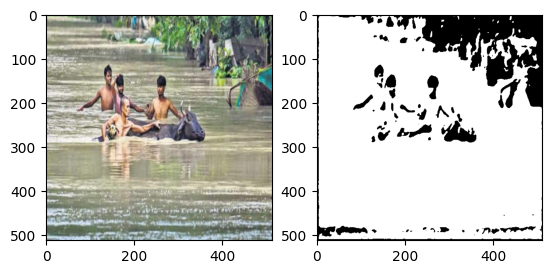

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image


def pred_show_image_grid(data_path, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = CarvanaDataset(data_path, test=True)
    images = []
    orig_masks = []
    pred_masks = []

    for img, orig_mask in image_dataset:
        img = img.float().to(device)
        img = img.unsqueeze(0)

        pred_mask = model(img)

        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        pred_mask = pred_mask.squeeze(0).cpu().detach()
        pred_mask = pred_mask.permute(1, 2, 0)
        pred_mask[pred_mask < 0]=0
        pred_mask[pred_mask > 0]=1

        orig_mask = orig_mask.cpu().detach()
        orig_mask = orig_mask.permute(1, 2, 0)

        images.append(img)
        orig_masks.append(orig_mask)
        pred_masks.append(pred_mask)

    images.extend(orig_masks)
    images.extend(pred_masks)
    fig = plt.figure()
    for i in range(1, 3*len(image_dataset)+1):
       fig.add_subplot(3, len(image_dataset), i)
       plt.imshow(images[i-1], cmap="gray")
    plt.show()


def single_image_inference(image_pth, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])

    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0]=0
    pred_mask[pred_mask > 0]=1

    fig = plt.figure()
    for i in range(1, 3):
        fig.add_subplot(1, 2, i)
        if i == 1:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(pred_mask, cmap="gray")
    plt.show()


if __name__ == "__main__":
    SINGLE_IMG_PATH = "/content/drive/MyDrive/project/unet_seg/data/valid/People-wade-through-a-flooded-street-along-with-th_1689275409804_jpg.rf.364ca50a901cd031fe81ecb9c07d7186.jpg"
    DATA_PATH = "/content/drive/MyDrive/project/unet_seg/data"
    MODEL_PATH = "/content/drive/MyDrive/project/unet_seg/model/unet_tes1_15.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    #pred_show_image_grid(DATA_PATH, MODEL_PATH, device)
    single_image_inference(SINGLE_IMG_PATH, MODEL_PATH, device)